# Forecasting epileptic seizures with generalized linear models (GLMs)
In this notebook, we will learn how to use GLMs to forecast epileptic seizures, using features extracted from the neural data

## Import libraries

In [ ]:
library(tscount)
library(ggplot2)
options(repr.matrix.max.cols=20, repr.matrix.max.rows=30)

## Import features
We will use features from one single patient, "JE". <br>
Raw data have already been preprocessed, and features extracted as shown in the first notebook focusing on features. <br>
Features are stored as csv files in the 'data' folder, one csv file per patient. 

In [2]:
patient = "JE"
path.data = 'data/'

In [3]:
data = read.csv(paste0(path.data, 'features_day_', patient, '_acausal4.csv'))

In the csv file, we find one column per feature, with the header of the column giving the name of the feature. For instance, 'Seizures' correspond to the seizure time series, and 'IEA' to the IEA time series. We also have several circardian and multidien rhythms which have been extracted, we will us the first (shortest) multidien rhythm for this patient, here called 'MultidienCos1' and 'MultidienSin1'.

In [4]:
data[,c('Time', 'Seizures', 'IEA_1', 'MultidienCos1', 'MultidienSin1')]

Time,Seizures,IEA_1,MultidienCos1,MultidienSin1
733973,0,-0.68895713,0.5090592,-0.8607315
733974,0,-0.39776513,0.9282240,-0.3720217
733975,2,-0.04526954,0.9862399,0.1653207
733976,0,0.53711447,0.7714323,0.6363114
733977,0,-0.48205755,0.3488973,0.9371609
733978,0,-0.58933882,-0.1838678,0.9829510
733979,0,-0.67363124,-0.6887002,0.7250462
733980,1,-0.78091250,-0.9413541,0.3374202
733981,0,-0.78091250,-0.8579387,-0.5137521
733982,3,0.65205868,-0.2171860,-0.9761302


## Select data of interest

We now select our features from the data dataframe, and put them in a matrix format.

In [5]:
# We need the daily timestamps
t = as.matrix(data['Time'])
# And the two types of raw data, seizures (Sz) and Interictal epileptiform activity (IEA)
data.Sz = as.matrix(data['Seizures'])
data.IEA = as.matrix(data[ , grepl('IEA_1', names(data)), drop=FALSE])
# We also include some covariates, here the multidien cycle found in our continuous timeseries IEA. 
cov.multi.IEA = as.matrix(data[ , grepl('MultidienCos1', names(data)) | grepl('MultidienSin1', names(data)), drop=FALSE])


We binarize seizure time series, as we are mostly interested to know if there is a seizure on a given day or not, and not necessarily how many seizures there are. In other words, we transform count data in point data. 

In [6]:
threshold = 1  # for patients with low number of seizures
category.data.Sz = data.Sz
category.data.Sz[category.data.Sz<threshold] = 0
category.data.Sz[category.data.Sz>0] = 1
data.Sz = category.data.Sz
# We have re-defined the seizure timeseries as binary. 

 ## Length of training, validation, and test set

To build the covariates based on the IEA and seizure histoy, we will need to remove a few data points at the beginning of the time series. The exact number of data points will depend on the length of the history. 
So, to ensure we evaluate algorithms on a test set which always has the same length and ease future comparisons, we systematically remove a few points at the beginning of the time series, whose length is given by the parameter IEA.eval.

In [7]:
eval.cut = 6

Here we set the length of the training sets. The length of training set is as short as possible, such as to leave plenty of data for testing, which will turn out to be very important in our probabilistic framework later on. We take 60% of data when the entire data at disposal is short, but a maximum of 384 days (1 year) for longer datasets.

In [8]:
length.train = min(floor(0.60*length(data.Sz)), 48*8) - (eval.cut + 1)
paste('The length of the training dataset is', length.train, 'days')

[1] "The length of the training dataset is 317 days"

## Forecasting seizures using  only seizure history
We first want to check if we can forecast seizures just by using seizure history, that is, seizures that happened before or on the day n, to forecast the likelihood of seizures on day n + 1. <br>
We first prepare the train and test sets by cutting the seizure time series into two chronological parts. The first part will serve for the training, the second part for the testing. 

In [9]:
t.cut = t[eval.cut:length(t)]
data.Sz.cut = data.Sz[eval.cut:length(data.Sz)]
paste('The length of the testing dataset is', length(data.Sz.cut)-length.train, 'days')

[1] "The length of the testing dataset is 218 days"

In [10]:
train.t = t.cut[1:length.train]
train.Sz = data.Sz.cut[1:length.train]
test.t = t.cut[(length.train+1):length(data.Sz.cut)]
test.Sz = data.Sz.cut[(length.train+1):length(data.Sz.cut)]

We now choose how many days of historical data as compared to the time of prediction we want to input in our GLM

In [11]:
history.Sz = 5

We now train our GLM. <br>
For this, we use the tsglm function of the tscount package. 

We will train the model using the train.Sz data, using observations based on all the five previous days.
Our GLM will use a log link function to avoid negative values for the output forecasts, and we fit a Poisson distribution.

Behind the hook, our GLM trained by tscount is given by the following formula:
$$ \log \lambda(t|S_{\{t-1, ..., t-5\}}) = \mu + \sum_{i=1}^5 a_i S_{t-i} $$
wth $\lambda(t|\cdot)$ the conditional intensity function, $S_t$ the seizure process, $\mu$ the background rate, and $a_i$ the model parameters to be estimated. 

In [12]:
Sz.with.Sz.fit = tsglm(train.Sz, 
                       model=list(past_obs=c(1:history.Sz)), # c() creates a vector in R
                       link="log", 
                       distr="poisson")

We now forecast using the test time series as input features, with the parameter n.ahead we take care of forecasting the next time point using previous history.

In [13]:
preds.test = predict(Sz.with.Sz.fit,
                     n.ahead=length((length.train+1):length(data.Sz.cut)),
                     newobs=test.Sz, 
                     method="conddistr", 
                     level=0)

We build a dataframe with the results.

In [14]:
df = data.frame(Time=test.t, Seizures=test.Sz, Forecasts.seizures=preds.test$pred)

We now plot the results: the forecast probability as a black line, and the actual seizures as red dots. If out forecast is good, seizures would occur when the forecast probability is high.

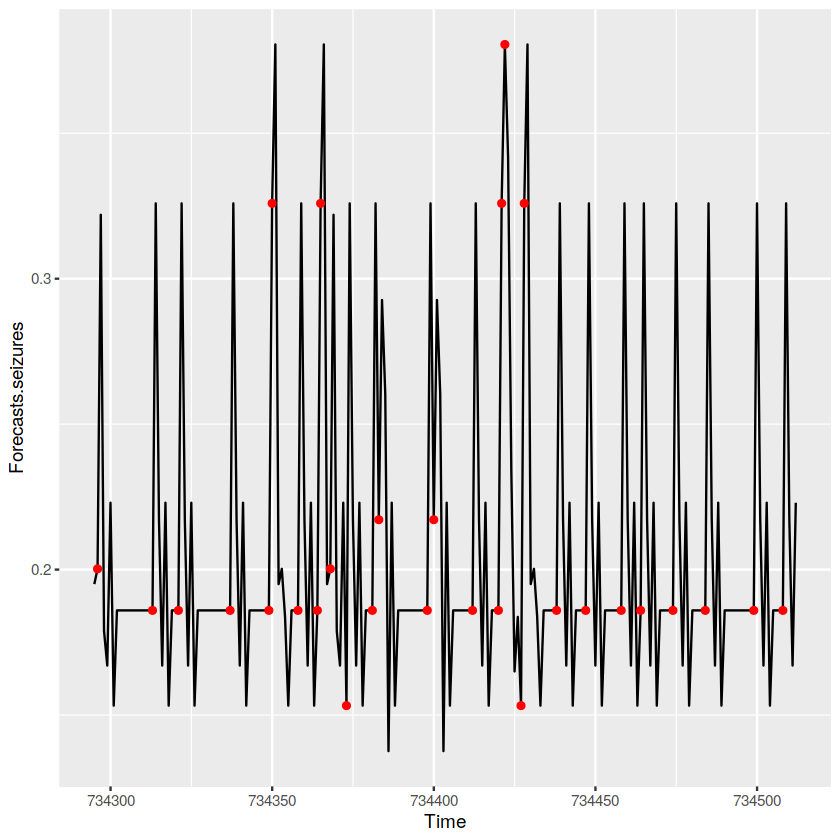

In [15]:
ggplot() + 
geom_line(data=df, mapping=aes(Time, Forecasts.seizures)) +  
geom_point(data=df[df$Seizures %in% 1,], mapping=aes(x=Time, y=Forecasts.seizures), color='red') 

As you can see, for this patient,the forecast based on the last 5 days of seizure history is not very good. Could we improve this forecast if we use instead the IEA history?

## Forecasting seizures using IEA history

We now tryforecast seizures just by using IEA history, that is, IEA that happened before or on the day n, to forecast the likelihood of seizures on day n + 1. To build the history, we need to set a list of the IEA.

In [16]:
history.IEA.list = c(1:5)

We then build a matrix, where we duplicate the IEA, but with each column shifted by the number of days indicated in history.IEA.list.

In [17]:
cov.IEA = data.IEA[1:(dim(data.IEA)[1]-1),,drop=FALSE]
for (ilag in c(2:length(history.IEA.list))){
    cov.IEA = cbind(cov.IEA[(1+history.IEA.list[ilag]-history.IEA.list[ilag-1]):dim(cov.IEA)[1],],
                    data.IEA[1:(dim(data.IEA)[1]-history.IEA.list[ilag]),])
    }

Let's have a look at the IEA covariate delayed matrix we obtained.

In [18]:
cov.IEA

-0.48205755,0.53711447,-0.04526954,-0.39776513,-0.68895713
-0.58933882,-0.48205755,0.53711447,-0.04526954,-0.39776513
-0.67363124,-0.58933882,-0.48205755,0.53711447,-0.04526954
-0.78091250,-0.67363124,-0.58933882,-0.48205755,0.53711447
-0.78091250,-0.78091250,-0.67363124,-0.58933882,-0.48205755
0.65205868,-0.78091250,-0.78091250,-0.67363124,-0.58933882
0.09266351,0.65205868,-0.78091250,-0.78091250,-0.67363124
-0.09124723,0.09266351,0.65205868,-0.78091250,-0.78091250
0.04668583,-0.09124723,0.09266351,0.65205868,-0.78091250
0.05434877,0.04668583,-0.09124723,0.09266351,0.65205868
-0.41309102,0.05434877,0.04668583,-0.09124723,0.09266351


We cut the first time points of the IEA delayed matrix, so that it matches to the previous section with seizure history.

In [19]:
cov.IEA.cut = cov.IEA[(eval.cut-length(history.IEA.list)):(length(data.Sz)-length(history.IEA.list)),,drop=FALSE]

We now prepare train and test sets with these IEA delayed matrices.

In [20]:
train.cov.IEA = cov.IEA.cut[1:(length.train),, drop=FALSE]
test.cov.IEA = cov.IEA.cut[(length.train+1):length(data.Sz.cut),, drop=FALSE]

We now train our GLM. 
This time, we only use the IEA delayed matrix as covariate, rather than building a model with history.
Our GLM will use, as above, a log link function to avoid negative values for the output forecasts, and we fit a Poisson distribution.

Behind the hook, our GLM trained by tscount is given by the following formula:
$$ \log \lambda(t|I_{\{t-1, ..., t-5\}}) = \mu + \sum_{i=1}^5 b_i I_{t-i} $$
wth $\lambda(t|\cdot)$ the conditional intensity function, $I_t$ the IEA process, $\mu$ the background rate, and $b_i$ the model parameters to be estimated. 

In [21]:
Sz.with.IEA.fit = tsglm(train.Sz, 
                        xreg=train.cov.IEA, 
                        link="log", 
                        distr="poisson")

We now forecast using the test IEA delayed matrix as covariate, with the parameter n.ahead we take care of forecasting the next time point using previous history.

In [22]:
preds.test = predict(Sz.with.IEA.fit, 
                     n.ahead=length((length.train+1):length(data.Sz.cut)),
                     newxreg=test.cov.IEA, level=0)

We add a colum to the dataframe with the results

In [23]:
df['Forecasts.IEA'] = preds.test$pred

We now plot the results: the forecast probability as a black line, and the actual seizures as red dots. If out forecast is good, seizures would occur when the forecast probability is high.

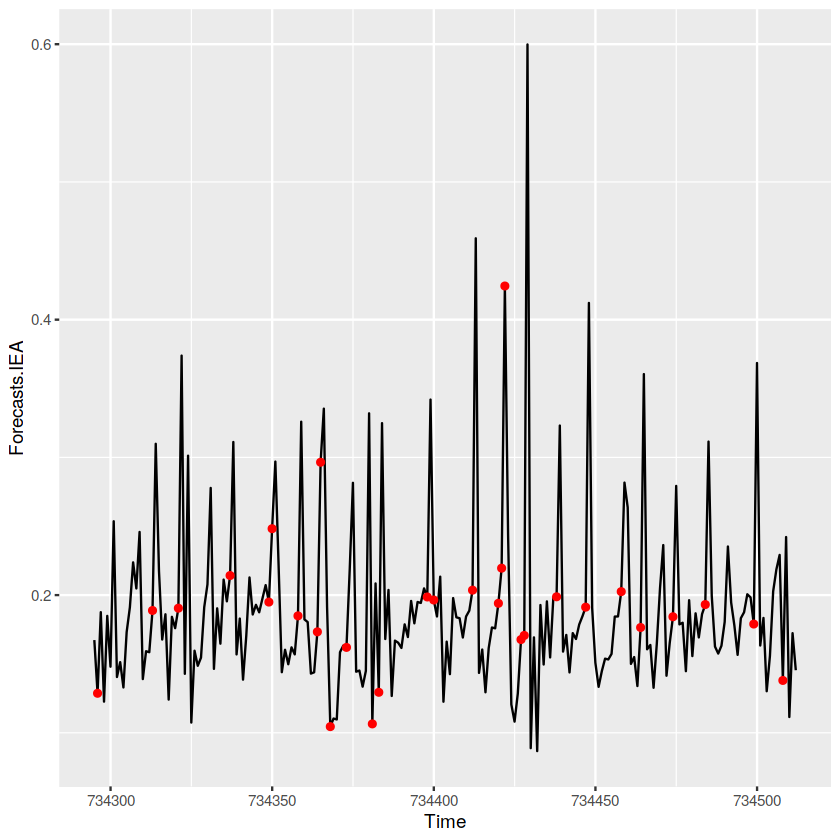

In [24]:
ggplot() + 
geom_line(data=df, mapping=aes(Time, Forecasts.IEA)) +  
geom_point(data=df[df$Seizures %in% 1,], mapping=aes(x=Time, y=Forecasts.IEA), color='red') 

The resulting forecasts look a bit more realistic than before, but still not particularly good. The forecasted increase in probability tends to follow the occurrence of a seizure rather than anticipate it. This may point to the fact that IEA and seizures have a non-zero phase-locking. 

## Forecasting seizures using multidien rhythms


 We now will forcast using the first multidien rhythm. For the multidien covariate, we first shift the time series forward and repeat the first time point to ensure causality of the forecats.

In [25]:
cov.multi.IEA = rbind(cov.multi.IEA[1,,drop=FALSE], cov.multi.IEA[1:(nrow(cov.multi.IEA) - 1),,drop=FALSE])

We cut the first time points of the multidien covariate, so that it matches to the previous sections with seizure and IEA history

In [26]:
cov.multi.IEA.cut = cov.multi.IEA[eval.cut:length(data.Sz),,drop=FALSE]
cov.multi.train.IEA = cov.multi.IEA.cut[1:length.train,,drop=FALSE]
cov.multi.test.IEA = cov.multi.IEA.cut[(length.train+1):length(data.Sz.cut),,drop=FALSE]

We now train our GLM. 
Once again, we only use the multidien covariate, rather than building a model with history.
Our GLM will use, as above, a log link function to avoid negative values for the output forecasts, and we fit a Poisson distribution.

Behind the hook, our GLM trained by tscount is given by the following formula:
$$ \log \lambda(t|X_{\{t-1\}}) = \mu + \sum_{k=1}^2 c_i X_{t-1}^k $$
wth $\lambda(t|\cdot)$ the conditional intensity function, $S_t$ the seizure process, $\mu$ the background rate, and $c_k$ the model parameters to be estimated. 

In [27]:
Sz.with.multi.fit = tsglm(train.Sz, xreg=cov.multi.train.IEA, link="log", distr="poisson")

We now forecast using the test multidien covariate, with the parameter n.ahead we take care of forecasting the next time point using previous history.

In [28]:
preds.test = predict(Sz.with.multi.fit, 
                     n.ahead=length((length.train+1):length(data.Sz.cut)), 
                     newxreg=cov.multi.test.IEA, 
                     level=0)

We add a colum to the dataframe with the results

In [29]:
df['Forecasts.multidien'] = preds.test$pred

We now plot the results: the forecast probability as a black line, and the actual seizures as red dots. If out forecast is good, seizures would occur when the forecast probability is high.

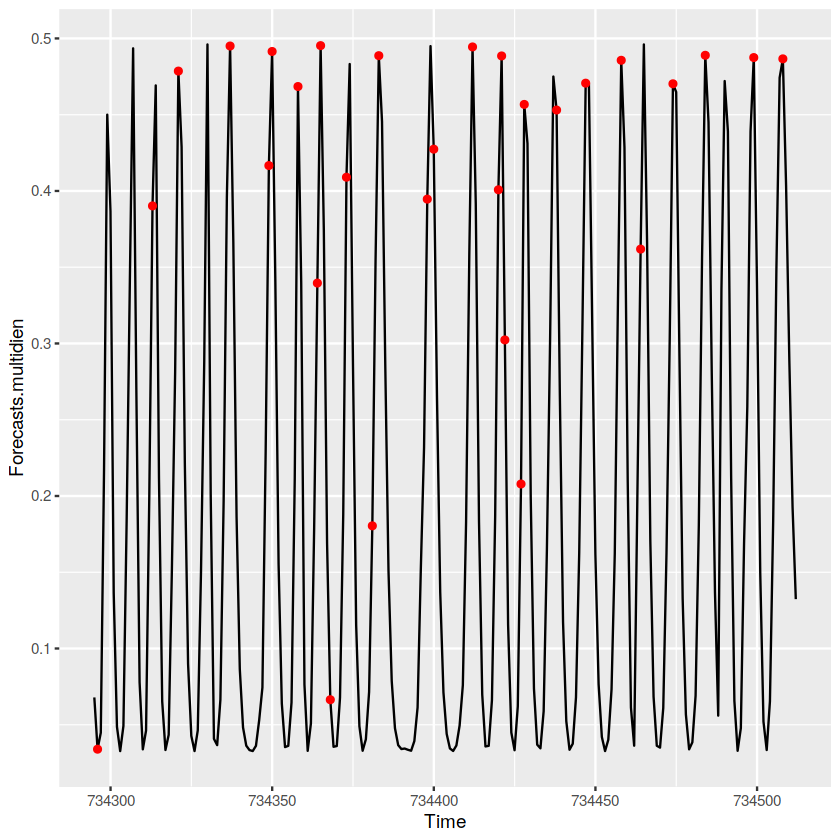

In [30]:
ggplot() + 
geom_line(data=df, mapping=aes(Time, Forecasts.multidien)) +  
geom_point(data=df[df$Seizures %in% 1,], mapping=aes(x=Time, y=Forecasts.multidien), color='red') 

This time, the forecasting results are pretty good, as the seizures (red dots) correspond well to the peak probabilities. In later notebooks, we will see how we can quantitatively characterize the present result. 

### Exercice

Try to perform the forecast, but this time using the weekly distribution of seizures

Answer

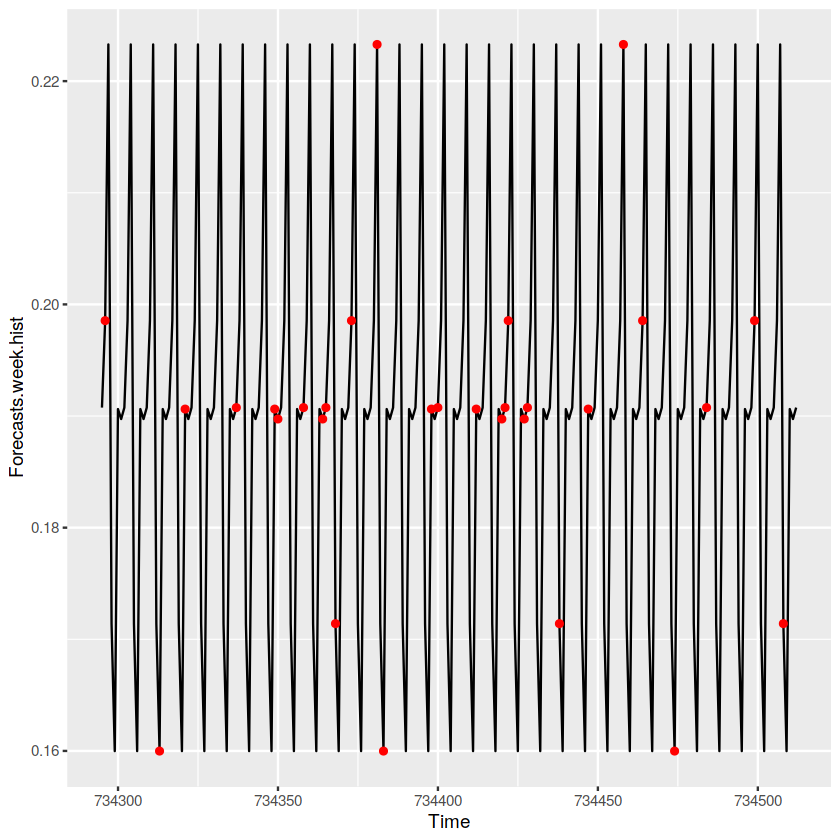